In [2]:
%pip install pytorch-pretrained-bert pytorch-nlp

import io

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from keras.utils import pad_sequences
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm, trange

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


2024-12-04 05:54:39.217504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 05:54:44.024595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import torch
from torch.utils.data import DataLoader

class DLoader(DataLoader):
    def __init__ (self, dataset, batch_size=64, max_batch_size=1024, shuffle=False, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
        self.start_iter = iter(self)
        self.current = 0
        self.batch_hist = []

        self.defaults = {
            "A": 0.0,
            "B": 0.0,
            "MaxB": max_batch_size,
            "k": 0,
            "b0": batch_size,
            "prev_len": 0,
            "next_len": batch_size,
            "len": batch_size,
            "beta": 0,
            "x": torch.Tensor([]),
            "grad": torch.Tensor([]),
            "prev_x": torch.Tensor([]),
            "prev_grad": torch.Tensor([]),
            "prev_beta": 0,
        }

    def step(self, params):
        x = torch.Tensor([])
        grad = torch.Tensor([])
        flag = True
        for p in params:
            if flag:
                flag = False
                x = torch.flatten(p.data)
                grad = torch.flatten(p.grad.data)
            else:
                x = torch.cat([x, torch.flatten(p.data)])

                grad = torch.cat([grad, torch.flatten(p.grad.data)])

        k = self.defaults["k"]
        if k == 0:
            self.defaults["grad"] = grad
            self.defaults["x"] = x
            self.defaults['k'] += 1
            self.defaults["next_len"] = min(self.defaults["len"] * 2, self.defaults["MaxB"])
            return

        self.defaults["prev_grad"] = self.defaults["grad"]
        self.defaults["prev_x"] = self.defaults["x"]
        self.defaults["grad"] = grad
        self.defaults["x"] = x
        beta = torch.dot(
            self.defaults["grad"] - self.defaults["prev_grad"],
            self.defaults["x"] - self.defaults["prev_x"]
        )
        self.defaults["len_prev"] = self.defaults["len"]
        self.defaults["len"] = self.defaults["next_len"]
        self.defaults["next_len"] = min(self.defaults["len"] * 2, self.defaults["MaxB"])
        self.defaults['beta'] = beta

        if k > 1:
            beta_prev = self.defaults["beta"]
            len_prev = self.defaults["len_prev"]
            len_curr = self.defaults["len"]

            if len_prev != len_curr:
                B = (beta_prev - beta) / (len_prev - len_curr)
                A = len_curr - beta * B
                self.defaults["A"] = A
                self.defaults["B"] = B

                next_len = max(1, min(self.defaults["MaxB"], self.defaults["B"] / (beta - A)))
                self.defaults["next_len"] = next_len

        self.defaults['k'] += 1

    def __iter__(self):
        self.start_iter = iter(super().__iter__())
        self.current = 0
        return self

    def __next__(self):
        if self.current < len(self):
            self.current += 1
            

            n = max(1, self.defaults["next_len"] // self.defaults["b0"])
            n = min(n, self.defaults["MaxB"] // self.defaults["b0"])
            self.batch_hist.append(self.defaults["b0"] * n)
            batches = []
            try:
                for _ in range(n):
                    batches.append(next(self.start_iter))
            except StopIteration:
                pass

            if len(batches) == 0:
                raise StopIteration

            first_batch = batches[0]
            for additional_batch in batches[1:]:
                for i, data in enumerate(additional_batch):
                    first_batch[i] = torch.cat([first_batch[i], data])

            return first_batch
        else:
            self.current = 0
            raise StopIteration

In [4]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

df = pd.read_csv(
    "in_domain_train.tsv",
    delimiter="\t",
    header=None,
    names=["sentence_source", "label", "label_notes", "sentence"],
)
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.1
)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
batch_size = 32
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
df

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
...,...,...,...,...
8546,ad03,0,*,Poseidon appears to own a dragon
8547,ad03,0,*,Digitize is my happiest memory
8548,ad03,1,NaN,It is easy to slay the Gorgon.
8549,ad03,1,NaN,I had the strangest feeling that I knew you.


In [5]:
all_losses_classicADAM = []
all_losses_adaptiveADAM = []
all_losses_classicSGD = []
all_losses_adaptiveSGD = []
all_bathes = []

In [6]:
#for optimizer, params in ((torch.optim.SGD, {"lr":1e-3}), torch.optim.Adam):
 #   for dataloader_class in (DataLoader, DLoader):
  #      opt = optimizer([x for x in model.parameters()], **params)

In [7]:
for tests in range(0, 2):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "gamma", "beta"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay_rate": 0.01,
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay_rate": 0.0,
        },
    ]

    optimizer =torch.optim.Adam(model.parameters(), lr=3e-4)
    validation_data = TensorDataset(validation_inputs, validation_labels)
    validation_sampler = SequentialSampler(validation_data)

    train_dataloader = DLoader(train_data, batch_size=batch_size, max_batch_size=96)

    validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    train_loss_set = []

    epochs = 2

    for _ in trange(epochs, desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            optimizer.zero_grad()
            loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
            for i in range(0, int(len(b_input_ids) / batch_size)):
                train_loss_set.append(loss.item())
            loss.backward()
            train_dataloader.step(model.parameters())
            optimizer.step()
            # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
        print("Train loss: {}".format(tr_loss / nb_tr_steps))

        # Validation

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:  # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_labels = batch
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                logits = model(b_input_ids, token_type_ids=None)

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            #print(tmp_eval_accuracy)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    all_losses_adaptiveADAM.append(train_loss_set)
    all_bathes.append(train_dataloader.batch_hist)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6168823629116812


Epoch:  50%|█████     | 1/2 [02:29<02:29, 149.68s/it]

Validation Accuracy: 0.7133487654320988
Train loss: 0.6136519253501259


Epoch: 100%|██████████| 2/2 [04:58<00:00, 149.15s/it]

Validation Accuracy: 0.711033950617284



Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.623198847184662


Epoch:  50%|█████     | 1/2 [02:27<02:27, 147.50s/it]

Validation Accuracy: 0.7129629629629629
Train loss: 0.6198019930683231


Epoch: 100%|██████████| 2/2 [04:56<00:00, 148.07s/it]

Validation Accuracy: 0.711033950617284


In [8]:
all_losses_classicADAM = []

In [9]:
for tests in range(0, 2):
    torch.cuda.empty_cache() 
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "gamma", "beta"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay_rate": 0.01,
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay_rate": 0.0,
        },
    ]

    optimizer =torch.optim.Adam(model.parameters(), lr=3e-4)
    validation_data = TensorDataset(validation_inputs, validation_labels)
    validation_sampler = SequentialSampler(validation_data)

    train_dataloader = DataLoader(train_data, batch_size=batch_size)

    validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle = True)
    train_loss_set = []

    epochs = 2

    for _ in trange(epochs, desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            optimizer.zero_grad()
            loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
            train_loss_set.append(loss.item())
            loss.backward()
            # train_dataloader.step(model.parameters())
            optimizer.step()

            # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss / nb_tr_steps))

        # Validation

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:  # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_labels = batch
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                logits = model(b_input_ids, token_type_ids=None)

        # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    all_losses_classicADAM.append(train_loss_set)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6178651601694432


Epoch:  50%|█████     | 1/2 [01:05<01:05, 65.89s/it]

Validation Accuracy: 0.7125771604938271
Train loss: 0.6141020967257963


Epoch: 100%|██████████| 2/2 [02:11<00:00, 65.89s/it]

Validation Accuracy: 0.7106481481481481



Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6208775619748222


Epoch:  50%|█████     | 1/2 [01:05<01:05, 65.84s/it]

Validation Accuracy: 0.711033950617284
Train loss: 0.6220712169572031


Epoch: 100%|██████████| 2/2 [02:11<00:00, 65.87s/it]

Validation Accuracy: 0.711033950617284


In [10]:
all_losses_adaptiveSGD = []

In [11]:
for tests in range(0, 2):
    torch.cuda.empty_cache() 
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "gamma", "beta"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay_rate": 0.01,
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay_rate": 0.0,
        },
    ]

    optimizer =torch.optim.SGD(model.parameters(), lr=1e-3)
    validation_data = TensorDataset(validation_inputs, validation_labels)
    validation_sampler = SequentialSampler(validation_data)

    train_dataloader = DLoader(train_data, batch_size=batch_size, max_batch_size=1024)

    validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
    train_loss_set = []

    epochs = 2

    for _ in trange(epochs, desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            optimizer.zero_grad()
            loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
            for i in range(0, int(len(b_input_ids) / batch_size)):
                train_loss_set.append(loss.item())
            loss.backward()
            train_dataloader.step(model.parameters())
            optimizer.step()
            # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
        all_bathes.append(train_dataloader.batch_hist)
        print("Train loss: {}".format(tr_loss / nb_tr_steps))

        # Validation

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:  # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_labels = batch
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                logits = model(b_input_ids, token_type_ids=None)

        # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    all_bathes.append(train_dataloader.batch_hist)
    all_losses_adaptiveSGD.append(train_loss_set)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6173077747540132


Epoch:  50%|█████     | 1/2 [02:25<02:25, 145.67s/it]

Validation Accuracy: 0.7125771604938271
Train loss: 0.611717288548521


Epoch: 100%|██████████| 2/2 [04:51<00:00, 145.75s/it]

Validation Accuracy: 0.7125771604938271



Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6100094758508577


Epoch:  50%|█████     | 1/2 [02:24<02:24, 144.47s/it]

Validation Accuracy: 0.7125771604938271
Train loss: 0.6060354770219177


Epoch: 100%|██████████| 2/2 [04:50<00:00, 145.20s/it]

Validation Accuracy: 0.7125771604938271


In [12]:
for tests in range(0, 2):
    torch.cuda.empty_cache() 
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "gamma", "beta"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay_rate": 0.01,
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay_rate": 0.0,
        },
    ]

    optimizer =torch.optim.SGD(model.parameters(), lr=1e-3)
    validation_data = TensorDataset(validation_inputs, validation_labels)
    validation_sampler = SequentialSampler(validation_data)

    train_dataloader = DataLoader(train_data, batch_size=batch_size)

    validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
    train_loss_set = []

    epochs = 2

    for _ in trange(epochs, desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_labels = batch
            optimizer.zero_grad()
            loss = model(b_input_ids, token_type_ids=None, labels=b_labels)
            train_loss_set.append(loss.item())
            loss.backward()
            # train_dataloader.step(model.parameters())
            optimizer.step()
            batch = tuple(t.to("cpu") for t in batch)
            # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        print("Train loss: {}".format(tr_loss / nb_tr_steps))

        # Validation

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:  # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_labels = batch
            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                logits = model(b_input_ids, token_type_ids=None)

        # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    all_losses_classicSGD.append(train_loss_set)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6133853947720587


Epoch:  50%|█████     | 1/2 [01:03<01:03, 63.23s/it]

Validation Accuracy: 0.7125771604938271
Train loss: 0.6041309291891043


Epoch: 100%|██████████| 2/2 [02:06<00:00, 63.25s/it]

Validation Accuracy: 0.7075617283950618



Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.6115798784489453


Epoch:  50%|█████     | 1/2 [01:03<01:03, 63.22s/it]

Validation Accuracy: 0.7125771604938271
Train loss: 0.6097042914248106


Epoch: 100%|██████████| 2/2 [02:06<00:00, 63.21s/it]

Validation Accuracy: 0.7125771604938271


In [22]:

#all_losses_classicSGD = np.array(all_losses_classicSGD)
#all_losses_adaptiveSGD = np.array(all_losses_adaptiveSGD)
#all_losses_classicADAM = np.array(all_losses_classicADAM)
#all_losses_adaptiveADAM = np.array(all_losses_adaptiveADAM)

AttributeError: 'numpy.ndarray' object has no attribute 'pop'

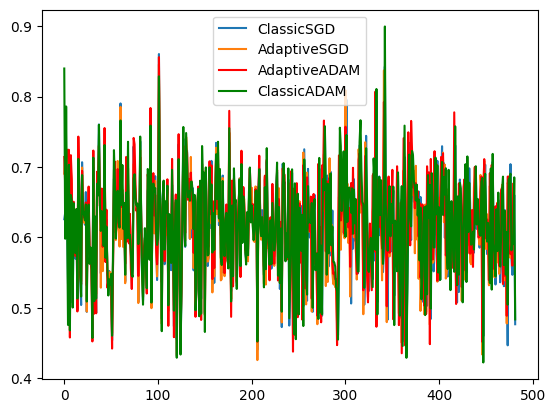

In [59]:

plt.plot((all_losses_classicSGD[0] + all_losses_classicSGD[1]) / 2, label = "ClassicSGD")
plt.plot((all_losses_adaptiveSGD[0] + all_losses_adaptiveSGD[1]) / 2, label = "AdaptiveSGD")
plt.legend()
plt.savefig('SGD_Graphics.png')
plt.plot((all_losses_adaptiveADAM[0] + all_losses_adaptiveADAM[1]) / 2, label = "AdaptiveADAM", color = 'red')
plt.plot((all_losses_classicADAM[0] + all_losses_classicADAM[1]) / 2, label = "ClassicADAM", color = 'green')
plt.legend()
plt.savefig('ADAM_Graphics.png')

479

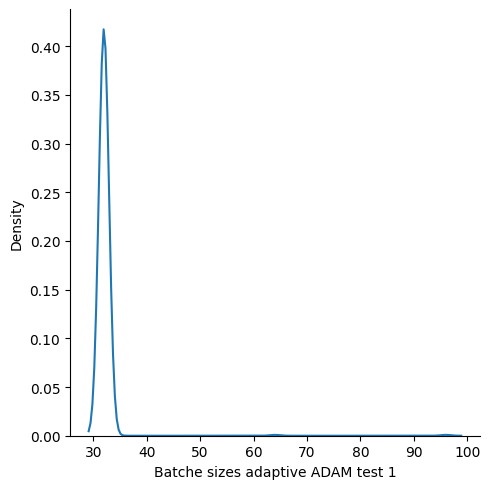

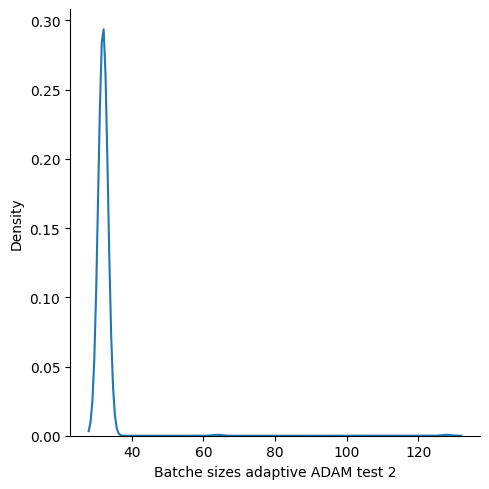

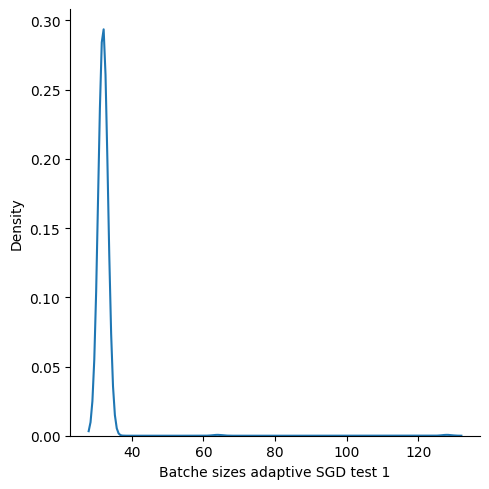

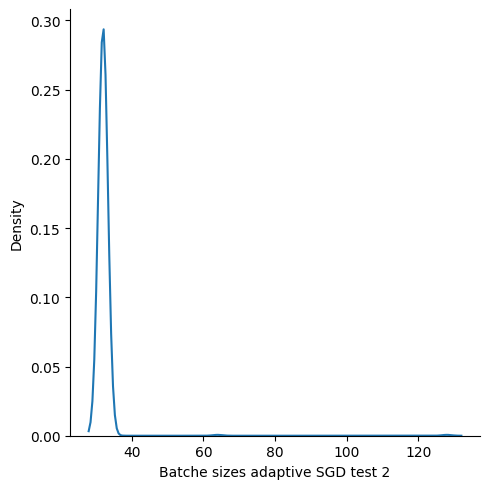

In [60]:

bathes_graphs = {'Batche sizes adaptive ADAM test 1' : all_bathes[0][:479],'Batche sizes adaptive ADAM test 2' : all_bathes[2],'Batche sizes adaptive SGD test 1' : all_bathes[4],'Batche sizes adaptive SGD test 2' : all_bathes[6]}

sns.displot(bathes_graphs,x ="Batche sizes adaptive ADAM test 1",   kind="kde")
plt.savefig("Batche sizes adaptive ADAM test 1")
sns.displot(bathes_graphs,x ="Batche sizes adaptive ADAM test 2",   kind="kde")
plt.savefig("Batche sizes adaptive ADAM test 2")
sns.displot(bathes_graphs,x ="Batche sizes adaptive SGD test 1",   kind="kde")
plt.savefig("Batche sizes adaptive SGD test 1")
sns.displot(bathes_graphs,x ="Batche sizes adaptive SGD test 2",   kind="kde")
plt.savefig("Batche sizes adaptive SGD test 2")

